In [2]:
%matplotlib inline

In [3]:
import pyart
import xarray as xr
import s3fs
import numpy as np
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.pyplot import cm as cmaps
import pandas as pd


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [4]:
# read in radar data
radar = pyart.io.read_nexrad_archive("s3://noaa-nexrad-level2/2021/05/26/KGLD/KGLD20210526_155623_V06")


In [5]:
# read in satellite data
fs = s3fs.S3FileSystem(anon=True)
aws_url = 's3://noaa-goes16/ABI-L2-MCMIPC/2021/146/15/OR_ABI-L2-MCMIPC-M6_G16_s20211461556154_e20211461558539_c20211461559030.nc'

goes_data = xr.open_dataset(fs.open(aws_url), engine='h5netcdf')


In [6]:
'''
Because the GOES data comes in without latitude/longitude values, we need to calculate those. 
'''

def lat_lon_reproj(g16nc):

    # GOES-R projection info and retrieving relevant constants
    proj_info = g16nc["goes_imager_projection"]
    lon_origin = proj_info.attrs["longitude_of_projection_origin"]
    H = proj_info.attrs["perspective_point_height"] + proj_info.attrs["semi_major_axis"]
    r_eq = proj_info.attrs["semi_major_axis"]
    r_pol = proj_info.attrs["semi_minor_axis"]

    # grid info
    lat_rad_1d = g16nc.variables["x"][:]
    lon_rad_1d = g16nc.variables["y"][:]

    # create meshgrid filled with radian angles
    lat_rad, lon_rad = np.meshgrid(lat_rad_1d, lon_rad_1d)

    # lat/lon calc routine from satellite radian angle vectors

    lambda_0 = (lon_origin * np.pi) / 180.0

    a_var = np.power(np.sin(lat_rad), 2.0) + (
        np.power(np.cos(lat_rad), 2.0)
        * (
            np.power(np.cos(lon_rad), 2.0)
            + (((r_eq * r_eq) / (r_pol * r_pol)) * np.power(np.sin(lon_rad), 2.0))
        )
    )
    b_var = -2.0 * H * np.cos(lat_rad) * np.cos(lon_rad)
    c_var = (H**2.0) - (r_eq**2.0)

    r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)

    s_x = r_s * np.cos(lat_rad) * np.cos(lon_rad)
    s_y = -r_s * np.sin(lat_rad)
    s_z = r_s * np.cos(lat_rad) * np.sin(lon_rad)

    lat = (180.0 / np.pi) * (
        np.arctan(
            ((r_eq * r_eq) / (r_pol * r_pol))
            * ((s_z / np.sqrt(((H - s_x) * (H - s_x)) + (s_y * s_y))))
        )
    )
    lon = (lambda_0 - np.arctan(s_y / (H - s_x))) * (180.0 / np.pi)

    return lon, lat


In [7]:
# First, we need to grid the input radar data. 
grid = pyart.map.grid_from_radars(radar, grid_shape=(41, 401, 401),
                                  grid_limits=((0.,20000,), (-200000., 200000.), (-200000, 200000.)))


/Users/seanfreeman/mambaforge/envs/tobac_dev/lib/python3.11/site-packages/pyart/graph/gridmapdisplay.py:243: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes with projection Mercator.
  warnings.warn(
/Users/seanfreeman/mambaforge/envs/tobac_dev/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


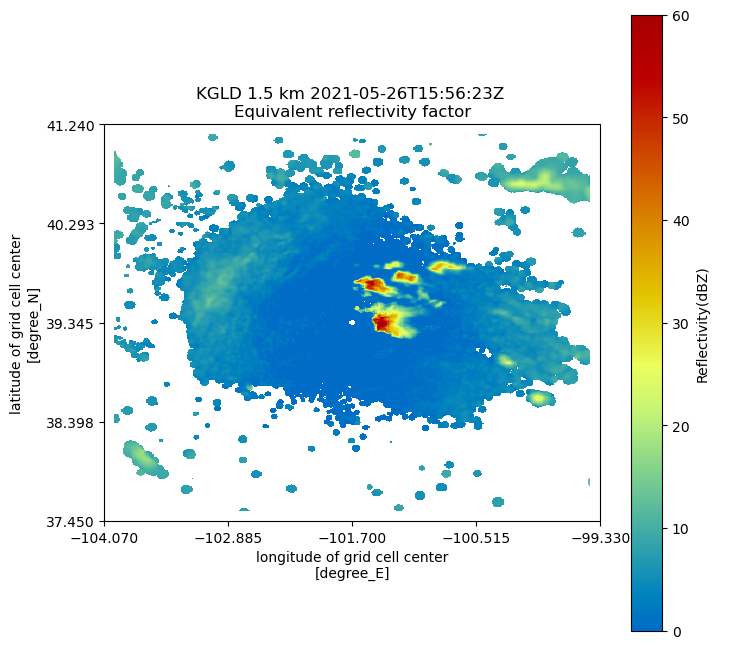

In [8]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[8, 8])
plt.axis('off')

display = pyart.graph.GridMapDisplay(grid)
display.plot_grid('reflectivity', level=3, vmin=0, vmax=60, fig=fig)


In [9]:
xr_grid = grid.to_xarray()

In [10]:
goes_data['time_bounds'][0].values

numpy.datetime64('2021-05-26T15:56:15.477525888')

In [11]:
goes_data['time_bounds'][0].values

numpy.datetime64('2021-05-26T15:56:15.477525888')

In [12]:
llons, llats  = lat_lon_reproj(goes_data)
full_goes_data = goes_data['CMI_C10'].values
in_goes_for_tobac = xr.Dataset(data_vars=
    {
        "C10": (("time","Y", "X"), [full_goes_data],)
    },
    coords=
    {
        "time": [goes_data['time_bounds'][0].values],
    "longitude": (["Y", "X"], llons),
    "latitude": (["Y", "X"], llats)},
)


/var/folders/bj/m6g82c6n41g83y3_dx02y7ch0000gp/T/ipykernel_29580/584919884.py:35: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-1.0 * b_var - np.sqrt((b_var**2) - (4.0 * a_var * c_var))) / (2.0 * a_var)


In [13]:
import tobac
import tobac.utils

In [14]:
feature_detection_params = dict()
feature_detection_params['threshold'] = [30, 40, 50]
feature_detection_params['target'] = 'maximum'
feature_detection_params['position_threshold'] = 'weighted_diff'
feature_detection_params['n_erosion_threshold'] = 2
feature_detection_params['sigma_threshold'] = 1
feature_detection_params['n_min_threshold'] = 4


In [15]:
xr_grid_full = xr_grid['reflectivity'][:,4]
xr_grid_full['z'] = xr_grid_full.z.assign_attrs({'standard_name': 'altitude'})
xr_grid_full['lat'] = xr_grid_full.lat.assign_attrs({'standard_name': 'latitude'})
xr_grid_full['lon'] = xr_grid_full.lon.assign_attrs({'standard_name': 'longitude'})


In [16]:
grid_iris = xr_grid_full.to_iris()


In [17]:
out_fd = tobac.feature_detection.feature_detection_multithreshold(grid_iris, 0, **feature_detection_params)

In [18]:
out_fd

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,altitude,latitude,longitude
0,0,5,258.862283,271.851509,19,30,1,2021-05-26 15:56:23,2021-05-26 15:56:23,58862.283394,71851.508790,71851.508790,39.872883,-100.885201
1,0,9,250.469609,240.740283,6,40,2,2021-05-26 15:56:23,2021-05-26 15:56:23,50469.609023,40740.283111,40740.283111,39.797444,-101.238116
2,0,11,198.778758,225.305252,54,50,3,2021-05-26 15:56:23,2021-05-26 15:56:23,-1221.241920,25305.251870,25305.251870,39.332809,-101.413212
3,0,12,243.316368,217.254572,7,50,4,2021-05-26 15:56:23,2021-05-26 15:56:23,43316.368018,17254.571781,17254.571781,39.733146,-101.504540


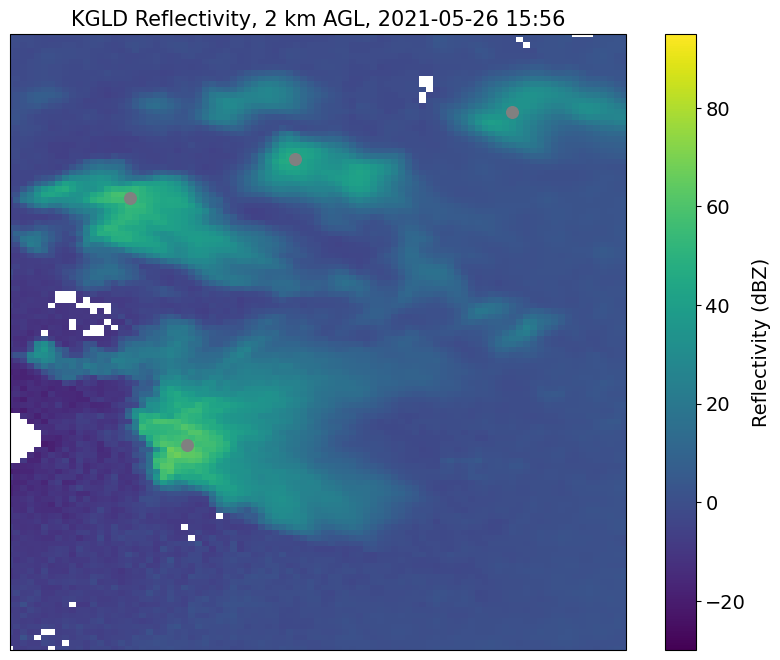

In [19]:
# we now have 4 detected features in 3D space. 

fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

cm = ax.pcolormesh(xr_grid['lon'], xr_grid['lat'], xr_grid['reflectivity'][0,4], vmin=-30, vmax=95, 
                  transform=ccrs.PlateCarree(), cmap = 'viridis')
plt.xlim(-101.7, -100.7)
plt.ylim(39., 40)
cb = plt.colorbar(cm)
cb.set_label("Reflectivity (dBZ)", size=14)
cb.ax.tick_params(labelsize=14)
plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
plt.scatter(out_fd['longitude'], out_fd['latitude'], 70, transform=ccrs.PlateCarree(), color='grey')


In [20]:
goes_array_iris = in_goes_for_tobac["C10"].to_iris()

In [21]:
in_goes_for_tobac

<xarray.Dataset>
Dimensions:    (time: 1, Y: 1500, X: 2500)
Coordinates:
  * time       (time) datetime64[ns] 2021-05-26T15:56:15.477525888
    longitude  (Y, X) float64 nan nan nan nan ... -61.97 -61.95 -61.93 -61.91
    latitude   (Y, X) float64 nan nan nan nan nan ... 14.64 14.64 14.64 14.64
Dimensions without coordinates: Y, X
Data variables:
    C10        (time, Y, X) float32 nan nan nan nan ... 264.4 264.4 264.5 264.7

In [22]:
goes_adj_features = tobac.utils.transform_feature_points(out_fd, goes_array_iris)

In [23]:
# the transformed dataframe needs to have identical time to the data to segment on. 
replacement_dt = np.datetime64(in_goes_for_tobac['time'][0].values, 's')
# however, iris cannot deal with times in ms, so we need to drop the ms values.

goes_adj_features['time'] = replacement_dt

In [24]:
field_time = goes_array_iris.slices_over("time")

In [25]:
goes_adj_features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,projection_y_coordinate,projection_x_coordinate,altitude,latitude,longitude
index,,,,,,,,,,,,,,
0,0.0,5.0,373.0,804.0,19.0,30.0,1.0,2021-05-26 15:56:15,2021-05-26 15:56:23,58862.283394,71851.508790,71851.508790,39.872883,-100.885201
1,0.0,9.0,377.0,790.0,6.0,40.0,2.0,2021-05-26 15:56:15,2021-05-26 15:56:23,50469.609023,40740.283111,40740.283111,39.797444,-101.238116
2,0.0,11.0,394.0,777.0,54.0,50.0,3.0,2021-05-26 15:56:15,2021-05-26 15:56:23,-1221.241920,25305.251870,25305.251870,39.332809,-101.413212
3,0.0,12.0,380.0,780.0,7.0,50.0,4.0,2021-05-26 15:56:15,2021-05-26 15:56:23,43316.368018,17254.571781,17254.571781,39.733146,-101.504540


In [26]:
parameters_segmentation=dict()
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=235
parameters_segmentation['target']='minimum'


In [27]:
seg_data, seg_feats = tobac.segmentation.segmentation(goes_adj_features, goes_array_iris, dxy=2000,**parameters_segmentation)

In [28]:
seg_data_xr = xr.DataArray.from_iris(seg_data)

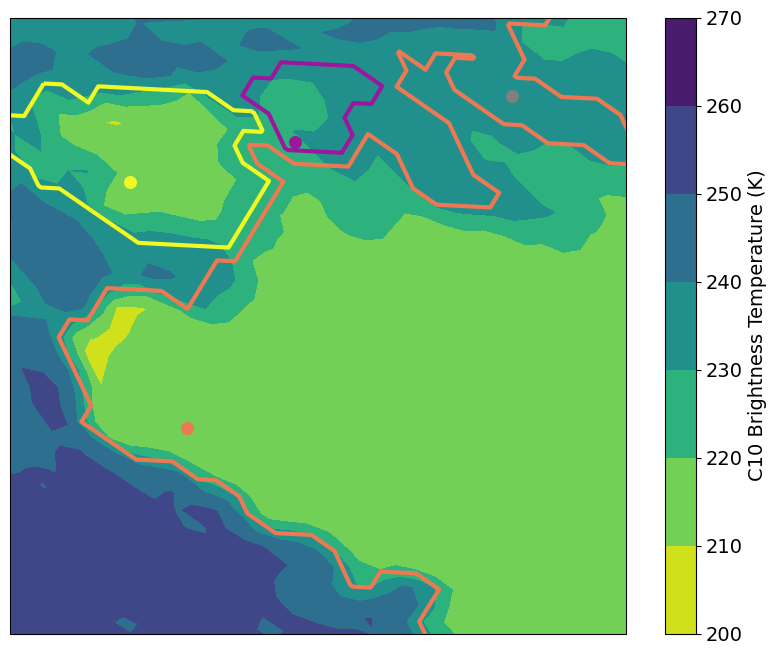

In [29]:
# In Py-ART's graphing suite, there is a display class similar to RadarMapDisplay,
# but for grids. To plot the grid:
fig = plt.figure(figsize=[10, 8])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-101.7, -100.7, 39, 40], crs=ccrs.PlateCarree())

contoured = ax.contourf(in_goes_for_tobac['longitude'], in_goes_for_tobac['latitude'], in_goes_for_tobac['C10'][0],
                  transform=ccrs.PlateCarree(), cmap = 'viridis_r')
plt.xlim(-101.7, -100.7)
plt.ylim(39., 40)
unique_seg = np.unique(seg_data_xr)
color_map = cmaps.plasma(np.linspace(0, 1, len(unique_seg)))

# we have one feature without a segmented area
curr_feat = goes_adj_features[goes_adj_features['feature']==1]
plt.scatter(curr_feat['longitude'], curr_feat['latitude'], 70, transform=ccrs.PlateCarree(), color='grey')


for seg_num, color in zip(unique_seg, color_map):
    if seg_num == 0:
        continue
    curr_seg = (seg_data_xr == seg_num).astype(int)
    ax.contour(seg_data_xr['longitude'], seg_data_xr['latitude'], curr_seg, colors=[color,], levels=[0.9,], linewidths=3)
    curr_feat = goes_adj_features[goes_adj_features['feature']==seg_num]
    plt.scatter(curr_feat['longitude'], curr_feat['latitude'], 70, transform=ccrs.PlateCarree(), color=color)

cb = plt.colorbar(contoured)
cb.set_label("C10 Brightness Temperature (K)", size=14)
cb.ax.tick_params(labelsize=14)
#plt.title("KGLD Reflectivity, 2 km AGL, 2021-05-26 15:56", size=15)
#plt.savefig("./radar_example_2/satellite_wseg.png", facecolor='w', bbox_inches='tight')